In [ ]:
ls Data


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as sktts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import cross_validate
from surprise import SVD, similarities
from surprise import Dataset, accuracy
from surprise import NormalPredictor
from surprise import Reader
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise import BaselineOnly
from wordcloud import WordCloud

In [5]:
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

In [3]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [4]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [5]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
movies

In [6]:
max_userid = ratings['userId'].drop_duplicates().max()

In [7]:
max_movieid = ratings['movieId'].drop_duplicates().max()

In [8]:
# Get summary statistics of rating
ratings['rating'].describe()


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

C:\Users\Derek\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

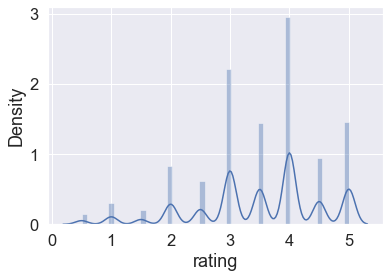

In [9]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

In [10]:
movies['genres'] = movies['genres'].str.split('|')
# Convert genres to string value
movies['genres'] = movies['genres'].fillna("").astype('str')

In [6]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

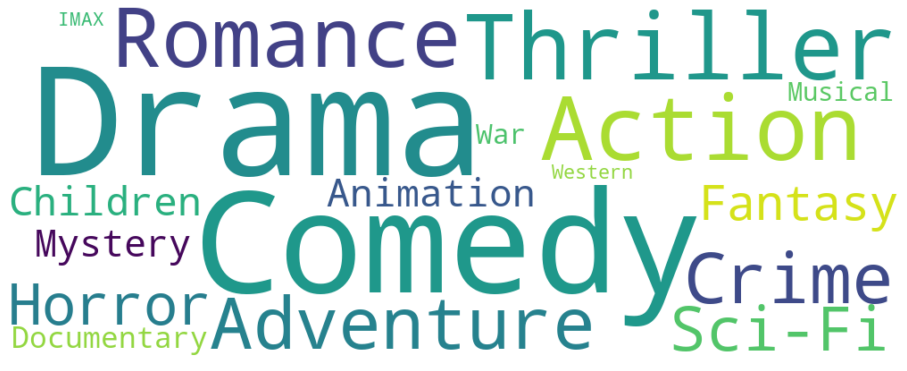

In [7]:
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
dataset = pd.merge(movies, ratings)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

In [30]:
rating_data = ratings.drop('timestamp', axis=1)

In [31]:
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(rating_data, reader=reader)

In [32]:
#use sklearn library train test split
y = pd.DataFrame(rating_data['rating'])
X= rating_data.drop('rating',axis=1)

X_train,X_test,y_train,y_test = sktts(X,y)

#remerge to convert using reader

train_df = pd.concat([X_train,y_train],axis=1)

test_df = pd.concat([X_test,y_test],axis=1)

#convert to surprise dataframes
trainset= Dataset.load_from_df(train_df, reader=reader)

testset = Dataset.load_from_df(test_df, reader=reader)

#make testset data usable for testing

blank,testset = train_test_split(testset, test_size=.95)

type(testset)

list

In [33]:
algo = SVD()
results = cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8751  0.8813  0.8896  0.8800  0.8961  0.8844  0.0075  
MAE (testset)     0.6753  0.6759  0.6830  0.6804  0.6879  0.6805  0.0047  
Fit time          8.14    8.38    8.57    8.53    8.34    8.39    0.15    
Test time         0.27    0.28    0.52    0.25    0.29    0.32    0.10    


In [ ]:
print("MAE on Train Set using 5 fold CV", results['train_mae'].mean())
print("RMSE on Train Set using 5 fold CV", results['train_rmse'].mean())

In [34]:
algo.predict(1,302,3)

Prediction(uid=1, iid=302, r_ui=3, est=4.17079973230242, details={'was_impossible': False})

In [29]:
# Average MAE and RMSE for Item Base Collaborative Filtering using 5 - Fold CF
sim_options = {
    "user_based": False,
}

knn_m = KNNWithMeans(sim_options=sim_options)
scores = cross_validate(knn_m, trainset , measures=['RMSE', 'MAE'], cv=5, verbose=True)

mean_mae = scores['test_mae'].mean()
mean_rsme = scores['test_rmse'].mean()

print(f'Average MAE: {mean_mae}')
print(f'Average RMSE: {mean_rsme}')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8894  0.8921  0.8918  0.8912  0.8982  0.8925  0.0030  
MAE (testset)     0.6781  0.6820  0.6823  0.6813  0.6848  0.6817  0.0022  
Fit time          9.74    9.69    9.74    8.98    9.36    9.50    0.30    
Test time         20.29   16.39   19.66   19.28   19.23   18.97   1.34    


KeyError: 'train_mae'

In [ ]:
# Average MAE and RMSE for User Base Collaborative Filtering using 5 - Fold CF
sim_options = {
    "user_based": True,
}

knn_m = KNNWithMeans(sim_options=sim_options)
scores = cross_validate(knn_m, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

mean_mae = scores['test_mae'].mean()
mean_rsme = scores['test_rmse'].mean()

print(f'Average MAE: {mean_mae}')
print(f'Average RMSE: {mean_rsme}')

In [ ]:
# Comparing Cosine, MSD, Pearson Similarities on Item Based CF
similarity_names = ['cosine','msd','pearson']
mean_mae_item = []
mean_rmse_item = []
for name in similarity_names:
  sim_options = {
    "user_based": False,
    "name": name
  }

  knn_m = KNNWithMeans(sim_options=sim_options)
  scores = cross_validate(knn_m, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

  mean_mae_item.append(scores['test_mae'].mean())
  mean_rmse_item.append(scores['test_rmse'].mean())

In [ ]:
print(f'Similarity Measure: {similarity_names}')
print(f'Average MAE: {mean_mae_item}')
print(f'Average RMSE: {mean_rmse_item}')

In [ ]:
# Comparing Cosine, MSD, Pearson Similarities on User Based CF
similarity_names = ['cosine','msd','pearson']
mean_mae_user = []
mean_rmse_user = []
for name in similarity_names:
  sim_options = {
    "user_based": True,
    "name": name
  }

  knn_m = KNNWithMeans(sim_options=sim_options)
  scores = cross_validate(knn_m, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

  mean_mae_user.append(scores['test_mae'].mean())
  mean_rmse_user.append(scores['test_rmse'].mean())

In [ ]:
print(f'Similarity Measure: {similarity_names}')
print(f'Average MAE: {mean_mae_user}')
print(f'Average RMSE: {mean_rmse_user}')

In [ ]:
ind = np.arange(len(similarity_names))
plt.figure(figsize=(10,5))
plt.bar(ind, mean_mae_item, 0.5, label='MAE')
plt.bar(ind + 0.5, mean_rmse_item, 0.5, label='RMSE')


plt.xlabel('measures')
plt.ylabel('scoring')


plt.legend(loc='best')
plt.show()


In [ ]:
ifig=1
labels = ['USER-BASED COLLAB. FILTERING', 'ITEM-BASED COLLAB. FILTERING']
x = np.arange(0, len(labels) * 2.5, 2.5)
width = 0.5
plt.figure(ifig)
fig, ax = plt.subplots(figsize=(18,5))
for i in range(len(similarity_names)):
    ax.bar(x - (width * len(similarity_names)) / 2 + i * width, [mean_mae_user[i], mean_mae_item[i]], width, label=similarity_names[i])
plt.xticks(x - width / 2, labels)
plt.title('ITEM AND USER BASED COLLABORATIVE FILTERING FOR MAE')
plt.ylabel('mae')
plt.grid(axis='y')
plt.legend()
plt.show()

In [ ]:
# Finding impact of k value for user based collaboration
ks = np.arange(1, 20, 1)


ub_mae = []
ub_rmse = []

for k in ks: 
    
    sim_options = {
    "user_based": True, 
    }
    
    
    knn_m = KNNWithMeans(k, sim_options=sim_options)
    scores = cross_validate(knn_m, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    
    mean_mae = scores['test_mae'].mean()
    mean_rsme = scores['test_rmse'].mean()
    
   
    ub_mae.append(mean_mae)
    ub_rmse.append(mean_rsme)

In [ ]:
# Finding impact of k value for item based collaboration
ib_mae = []
ib_rmse = []

for k in ks: 
    sim_options = {
    "user_based": False,  
    }
    
    knn_m = KNNWithMeans(k, sim_options=sim_options)
    scores = cross_validate(knn_m, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    mean_mae = scores['test_mae'].mean()
    mean_rsme = scores['test_rmse'].mean()
    
    ib_mae.append(mean_mae)
    ib_rmse.append(mean_rsme)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ks, ub_rmse)
plt.title('NEIGHBOURS FOR RMSE ON USER-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('RMSE')

plt.show()

plt.figure(figsize=(10,5))
plt.plot(ks, ib_rmse)
plt.title('NEIGHBOURS FOR RMSE ON ITEM-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('RMSE')

plt.show()

plt.figure(figsize=(10,5))
plt.plot(ks, ub_mae)
plt.title('NEIGHBOURS FOR MAE ON USER-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('MAE')

plt.show()

plt.figure(figsize=(10,5))
plt.plot(ks, ib_mae)
plt.title('NEIGHBOURS FOR RMSE ON ITEM-BASED COLLAB. FILTERING')
plt.xlabel('neighbors')
plt.ylabel('MAE')


plt.show()

In [ ]:
#Showing the best value for K for each collab 
print('USER-BASED COLLAB. FILTERING - MAE')
print('Best K: ', ks[np.argmin(ub_mae)])
print('Best K MAE: ', np.min(ub_mae))

print('\nUSER-BASED COLLAB. FILTERING - RMSE')
print('Best K: ', ks[np.argmin(ub_rmse)])
print('Best K RMSE: ', np.min(ub_rmse))

print('\nITEM-BASED COLLAB. FILTERING - MAE')
print('Best K: ', ks[np.argmin(ib_mae)])
print('Best K MAE: ', np.min(ib_mae))

print('\nITEM-BASED COLLAB. FILTERING - RMSE')
print('Best K: ', ks[np.argmin(ib_rmse)])
print('Best K RMSE: ', np.min(ib_rmse))

In [38]:
#Average MAE and RMSE for User Base Collaborative Filtering using 5 - Fold CF
sim_options = {
    "user_based": True,
    'name':'Cosine'
}

knn_m = KNNWithMeans(k=19, sim_options=sim_options)
scores = cross_validate(knn_m, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

mean_mae = scores['test_mae'].mean()
mean_rsme = scores['test_rmse'].mean()

print(f'Average MAE: {mean_mae}')
print(f'Average RMSE: {mean_rsme}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9110  0.9214  0.9115  0.9143  0.9169  0.9150  0.0038  
MAE (testset)     0.6996  0.7053  0.6993  0.7027  0.7034  0.7020  0.0023  
Fit time          0.94    0.89    0.91    0.93    0.98    0.93    0.03    
Test time         2.04    2.18    2.07    2.28    2.29    2.17    0.11    
Average MAE: 0.702036656305484
Average RMSE: 0.9149963131801003
